<a href="https://colab.research.google.com/github/carlm451/Gemstone_Images_Classification_Fine_Tuning/blob/main/Gemstones_Classifier_Model_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

import os
import matplotlib.pyplot as plt
from random import shuffle 

#will use MobileNetV2... efficient pretrained model we can fine-tune easily 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


In [3]:
# pulling gemstones data from kaggle
#!pip install kaggle

!mkdir ~/.kaggle

#need a kaggle API key kaggle.json
!mv kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [4]:
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download lsind18/gemstones-images

gemstones-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip gemstones-images.zip &> /dev/null  #suppress terminal output when unzipping images
!ls 

gemstones-images.zip  sample_data  test  train	training_1  training_2	val


In [7]:
#going to split of some of the training data for a validation data set
!mkdir val

mkdir: cannot create directory ‘val’: File exists


In [8]:
import os

data_dir = '/content'

train_dir = os.path.join(data_dir,'train')

val_dir = os.path.join(data_dir,'val')

test_dir = os.path.join(data_dir,'test')

def count_img_samples(directory):
    
    count = 0
    
    for i,gem_type in enumerate(os.listdir(directory)):
        
        gem_dir = os.path.join(directory,gem_type)
    
        img_list = os.listdir(gem_dir)

        #print(f' dir {gem_dir} has {len(img_list)} images')

        count += len(img_list)
    
    return count

n_train = count_img_samples(train_dir)
n_test = count_img_samples(test_dir)
n_val = count_img_samples(val_dir)

print(f'{n_train=}, {n_val=}, {n_test=}')

n_train=2434, n_val=422, n_test=363


In [9]:
from random import shuffle

def partition_val_data(train_dir,val_dir,val_split=0.1):
    
    for gem_type in os.listdir(train_dir):
        
        train_gem_dir = os.path.join(train_dir,gem_type)
        
        img_list = os.listdir(train_gem_dir)
        
        shuffle(img_list)
        
        n_samples = round(len(img_list)*val_split)
        
        val_img_list = img_list[:n_samples] # take n_samples random images to move
        
        val_gem_dir = os.path.join(val_dir,gem_type)
        
        if not os.path.exists(val_gem_dir):
            
            os.mkdir(val_gem_dir)
            
            for gem_img in val_img_list:
                
                original_path = os.path.join(train_gem_dir,gem_img)
                
                destination_path = os.path.join(val_gem_dir,gem_img)
                
                os.rename(original_path,destination_path)
        
            print(f'Moved {len(os.listdir(val_gem_dir))} training images from to {val_gem_dir}')
            
        else:
            
            print(f'Val dir {val_gem_dir} has {len(os.listdir(val_gem_dir))} images')

In [10]:
val_split=0.15  # move 15% train to use for validation

partition_val_data(train_dir,val_dir,val_split)

Val dir /content/val/Spessartite has 4 images
Val dir /content/val/Chrysoberyl has 5 images
Val dir /content/val/Opal has 5 images
Val dir /content/val/Citrine has 6 images
Val dir /content/val/Iolite has 5 images
Val dir /content/val/Zoisite has 4 images
Val dir /content/val/Pearl has 5 images
Val dir /content/val/Chrysoprase has 4 images
Val dir /content/val/Amber has 5 images
Val dir /content/val/Turquoise has 5 images
Val dir /content/val/Danburite has 5 images
Val dir /content/val/Spodumene has 5 images
Val dir /content/val/Sapphire Blue has 5 images
Val dir /content/val/Almandine has 5 images
Val dir /content/val/Andradite has 5 images
Val dir /content/val/Diaspore has 5 images
Val dir /content/val/Aventurine Green has 7 images
Val dir /content/val/Kunzite has 5 images
Val dir /content/val/Scapolite has 4 images
Val dir /content/val/Labradorite has 6 images
Val dir /content/val/Variscite has 4 images
Val dir /content/val/Sapphire Yellow has 5 images
Val dir /content/val/Chrysocol

In [11]:
!ls val

gem_types_list = os.listdir(val_dir)

n_classes = len(gem_types_list)

print(f'{n_classes} classes of gemstone')

 Alexandrite	      Chrysocolla     Larimar		 'Sapphire Blue'
 Almandine	      Chrysoprase     Malachite		 'Sapphire Pink'
 Amazonite	      Citrine	      Moonstone		 'Sapphire Purple'
 Amber		      Coral	      Morganite		 'Sapphire Yellow'
 Amethyst	      Danburite      'Onyx Black'	  Scapolite
 Ametrine	      Diamond	     'Onyx Green'	  Serpentine
 Andalusite	      Diaspore	     'Onyx Red'		  Sodalite
 Andradite	      Dumortierite    Opal		  Spessartite
 Aquamarine	      Emerald	      Pearl		  Sphene
'Aventurine Green'    Fluorite	      Peridot		  Spinel
'Aventurine Yellow'  'Garnet Red'     Prehnite		  Spodumene
 Benitoite	      Goshenite       Pyrite		  Sunstone
'Beryl Golden'	      Grossular       Pyrope		  Tanzanite
 Bixbite	      Hessonite      'Quartz Beer'	 'Tigers Eye'
 Bloodstone	      Hiddenite      'Quartz Lemon'	  Topaz
'Blue Lace Agate'     Iolite	     'Quartz Rose'	  Tourmaline
 Carnelian	      Jade	     'Quartz Rutilated'   Tsavorite
'Cats Eye'	      Jasper	     'Quartz 

In [12]:
from tensorflow.keras.utils import load_img, img_to_array

def get_img_array(directory,gem_type):
    
    gem_dir = os.path.join(directory,gem_type)
    
    img_list = os.listdir(gem_dir)
    
    #shuffle(img_list)
    
    img_path = os.path.join(gem_dir,img_list[0])
    
    img = load_img(img_path)
    
    x = img_to_array(img) / 255.
    
    return x

def get_img_array_resized(directory,gem_type):
    
    gem_dir = os.path.join(directory,gem_type)
    
    img_list = os.listdir(gem_dir)
    
    #shuffle(img_list)
    
    img_path = os.path.join(gem_dir,img_list[0])
    
    img = load_img(img_path,target_size=(224,224),keep_aspect_ratio=False)
    
    x = img_to_array(img) / 255.
    
    return x

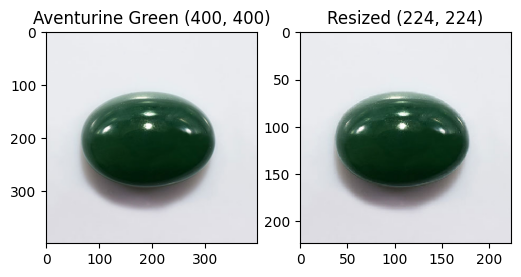

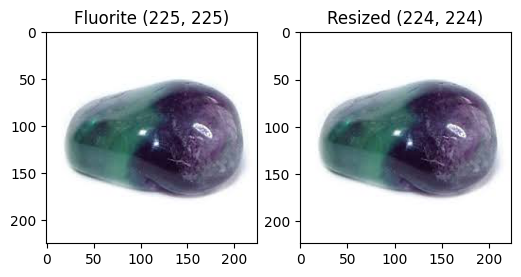

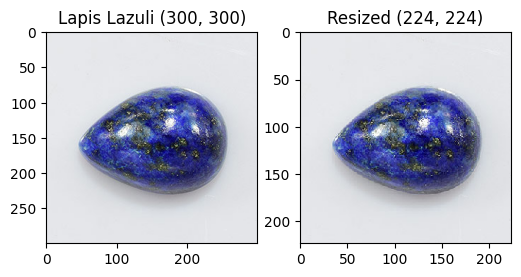

In [13]:
import matplotlib.pyplot as plt

shuffle(gem_types_list)

for gem_type in gem_types_list[:3]:

    sample_x = get_img_array(train_dir,gem_type)

    sample_x_resized = get_img_array_resized(train_dir,gem_type)

    fix, (ax1,ax2) =plt.subplots(1,2,figsize=(6,6))

    ax1.imshow(sample_x)
    ax1.set_title(f'{gem_type} {sample_x.shape[:2]}')

    ax2.imshow(sample_x_resized)
    ax2.set_title(f'Resized {sample_x_resized.shape[:2]}')

    plt.show()

In [14]:
# generators to stream images for training/validation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                   rotation_range=90,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   zoom_range=0.5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

val_datagen  = ImageDataGenerator( rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    keep_aspect_ratio=False,
                                                    classes=gem_types_list) 

val_generator = val_datagen.flow_from_directory(val_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                    keep_aspect_ratio=False,
                                                    classes=gem_types_list) 

Found 2434 images belonging to 87 classes.
Found 422 images belonging to 87 classes.


In [21]:
def get_uncompiled_model(n_classes, model_name,fine_tune=0):

    tf.keras.backend.clear_session()

    pretrained = MobileNetV2(include_top=False, pooling='avg',input_shape=(224,224,3))

    if fine_tune > 0:
        for layer in pretrained.layers[:-fine_tune]:
            layer.trainable = False
    else:
        pretrained.trainable=False #freezes all children layers 

    model = tf.keras.models.Sequential(name=model_name)
    model.add(pretrained)
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(n_classes))
    
    return model

In [16]:
model_1 = get_uncompiled_model(n_classes,model_name='mobilenetV2_frozen')
    
model_1.summary()

#checking that the input size is correct, should be (224,224,3)
model_1.input

Model: "mobilenetV2_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 87)                111447    
                                                                 
Total params: 2,369,431
Trainable params: 111,447
Non-trainable params: 2,257,984
_________________________________________________________________


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'mobilenetv2_1.00_224_input')>

In [17]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(0.003),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [18]:
!rm -r training_1

!mkdir training_1

In [19]:
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

N_EPOCHS=25

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq='epoch')

history_1 = model_1.fit(
            train_generator,
            epochs=N_EPOCHS,
            validation_data=val_generator,
            verbose=1,
            callbacks=[cp_callback]
            )

Epoch 1/25
39/39 [==============================] - ETA: 0s - loss: 3.7412 - categorical_accuracy: 0.1791
Epoch 1: saving model to training_1/cp-0001.ckpt
39/39 [==============================] - 42s 943ms/step - loss: 3.7412 - categorical_accuracy: 0.1791 - val_loss: 2.3823 - val_categorical_accuracy: 0.3815
Epoch 2/25
39/39 [==============================] - ETA: 0s - loss: 2.1430 - categorical_accuracy: 0.4158
Epoch 2: saving model to training_1/cp-0002.ckpt
39/39 [==============================] - 35s 902ms/step - loss: 2.1430 - categorical_accuracy: 0.4158 - val_loss: 1.9391 - val_categorical_accuracy: 0.5071
Epoch 3/25
39/39 [==============================] - ETA: 0s - loss: 1.8336 - categorical_accuracy: 0.5029
Epoch 3: saving model to training_1/cp-0003.ckpt
39/39 [==============================] - 35s 891ms/step - loss: 1.8336 - categorical_accuracy: 0.5029 - val_loss: 1.7718 - val_categorical_accuracy: 0.5261
Epoch 4/25
39/39 [==============================] - ETA: 0s - loss:

Text(0.5, 1.0, 'Training and validation loss')

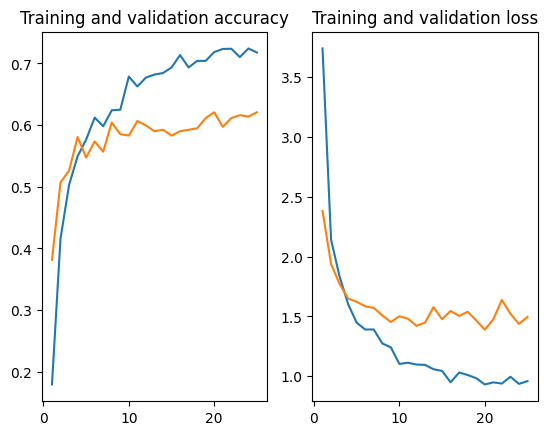

In [20]:
acc      = history_1.history['categorical_accuracy']
val_acc  = history_1.history['val_categorical_accuracy']
loss     = history_1.history['loss']
val_loss = history_1.history['val_loss' ]

epochs   = np.arange(len(acc)) + 1 # Get number of epochs

fig, (ax1,ax2) = plt.subplots(1,2)

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
ax1.plot  ( epochs,     acc )
ax1.plot  ( epochs, val_acc )
ax1.set_title ('Training and validation accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
ax2.plot  ( epochs,     loss )
ax2.plot  ( epochs, val_loss )
ax2.set_title ('Training and validation loss'   )

## Fine-tune, allow small number of final MobileNet layers to train

* see if can improve beyond val_acc ~0.60 simply by fine-tuning last layers of the mobilenetv2 model

* will take the best validation accuracy from the base model above, and try fine tuning with a smaller learning rate. The idea being that now that the final classifier layer is tuned to the current data set, we can make small needed adjustments to the pretrained weights in the final layers that were frozen before.  This is the advised strategy from tensorflow docs, see the "Fine Tuning" section: https://www.tensorflow.org/tutorials/images/transfer_learning




In [41]:
latest = tf.train.latest_checkpoint('training_1')
latest #filename of the latest checkpoint

# from manual inspection of val accuracy
#best_epoch=14
#best = os.path.join('training_1',f'cp-{best_epoch:04d}.ckpt')
#best

'training_1/cp-0014.ckpt'

In [1]:
fine_tune_count = 20

fine_tune_name = 'mobilenet_finetune_'+str(fine_tune_count)

model_finetune = get_uncompiled_model(n_classes,model_name=fine_tune_name,fine_tune=fine_tune_count)
    
model_finetune.summary()

model_finetune.input

NameError: ignored

In [43]:
!rm -r training_2

!mkdir training_2

In [44]:
#start from checkpoint for best model 
model_finetune.load_weights(best)

#use smaller learning rate for fine-tuning... 0.0001 
model_finetune.compile(optimizer=tf.keras.optimizers.Adam(0.00005),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [45]:
class AccCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 60 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('categorical_accuracy') >= 0.9):

      # Stop if threshold is met
      print("\nReached 0.8 target training accuracy")
      self.model.stop_training = True

# Instantiate class
train_acc_callback = AccCallback()

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [46]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq='epoch')

history_finetune = model_finetune.fit(
            train_generator,
            epochs=32,
            validation_data=val_generator,
            verbose=1,
            callbacks=[cp_callback,train_acc_callback,stop_callback]
            )

Epoch 1/32
39/39 [==============================] - ETA: 0s - loss: 1.5326 - categorical_accuracy: 0.5694
Epoch 1: saving model to training_2/cp-0001.ckpt
39/39 [==============================] - 40s 899ms/step - loss: 1.5326 - categorical_accuracy: 0.5694 - val_loss: 1.4055 - val_categorical_accuracy: 0.5995
Epoch 2/32
39/39 [==============================] - ETA: 0s - loss: 1.2819 - categorical_accuracy: 0.6282
Epoch 2: saving model to training_2/cp-0002.ckpt
39/39 [==============================] - 34s 882ms/step - loss: 1.2819 - categorical_accuracy: 0.6282 - val_loss: 1.4055 - val_categorical_accuracy: 0.5948
Epoch 3/32
39/39 [==============================] - ETA: 0s - loss: 1.1267 - categorical_accuracy: 0.6738
Epoch 3: saving model to training_2/cp-0003.ckpt
39/39 [==============================] - 34s 880ms/step - loss: 1.1267 - categorical_accuracy: 0.6738 - val_loss: 1.4111 - val_categorical_accuracy: 0.5806
Epoch 4/32
38/39 [============================>.] - ETA: 0s - loss:

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Training and validation loss')

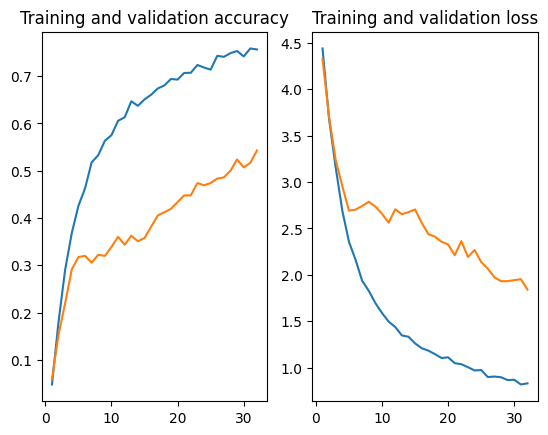

In [30]:
acc      += history_finetune.history['categorical_accuracy']
val_acc  += history_finetune.history['val_categorical_accuracy']
loss     += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss' ]

epochs   = np.arange(len(acc)) + 1 # Get number of epochs

fig, (ax1,ax2) = plt.subplots(1,2)

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
ax1.plot  ( epochs,     acc )
ax1.plot  ( epochs, val_acc )
ax1.axvline(16)
ax1.set_title ('Training and validation accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
ax2.plot  ( epochs,     loss )
ax2.plot  ( epochs, val_loss )
ax2.axvline(16)
ax2.set_title ('Training and validation loss'   )